<a href="https://colab.research.google.com/github/mario-rot/ComputerVisionCourse-MAI/blob/main/Session%207/P7_Mario_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
%%shell
git clone https://github.com/mario-rot/ComputerVisionCourse-MAI.git
cd 'ComputerVisionCourse-MAI'
mv 'Session 7/Caltech_101_subset' /content/
mv 'customplots.py' /content/
mv 'utils.py' /content/

fatal: destination path 'ComputerVisionCourse-MAI' already exists and is not an empty directory.
mv: cannot stat 'Session 7/Caltech_101_subset': No such file or directory
mv: cannot stat 'customplots.py': No such file or directory
mv: cannot stat 'utils.py': No such file or directory


CalledProcessError: ignored

In [7]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage import feature
from skimage.color import rgb2gray
from skimage.io import imread, imread_collection
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from utils import get_multi_ORB
from sklearn.cluster import MiniBatchKMeans
import collections
import skimage.exposure as ske

from matplotlib import pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from customplots import plot_confusion_matrix

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [9]:
# modify the dataset variable with the path from your drive

dataset_path = r'/content/Caltech_101_subset/'

In [10]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [11]:
data = [(cat, i) for cat in categories for i in imread_collection(dataset_path+ cat +'/*')]

In [12]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [56]:
# solution
X = [i for cat in categories for i in imread_collection(dataset_path+ cat +'/*')]
y = [cat for cat in categories for i in imread_collection(dataset_path+ cat +'/*')]
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=25, stratify=y)

In [57]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

*We used the train_test_split function from sklearn to split the data into a testing set and a training set. This selects the data randomly to split based off the percentage provided. We also set the 'stratify' parameter to ensure that there was a representative balance of images in each split.*

...

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [15]:
descriptor_extractor = feature.ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [16]:
# solution
kps_train,dcs_train = get_multi_ORB(descriptor_extractor, x_train)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [17]:
# solution
print('The size of each feature descriptors matrix per image is {}, where {} represents the number \n of keypoints identified and {} is a vector with values either being True or False representing\n the outcome of the intensity comparison for each keypoint on a decision pixel-pair.'.format(dcs_train[1].shape, dcs_train[1].shape[0], dcs_train[1].shape[1]))


The size of each feature descriptors matrix per image is (64, 256), where 64 represents the number 
 of keypoints identified and 256 is a vector with values either being True or False representing
 the outcome of the intensity comparison for each keypoint on a decision pixel-pair.


**Solution**

*See code cell above for solution*

...

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [20]:
# solution
dcs_flatten = np.reshape(dcs_train, (len(dcs_train)*dcs_train.shape[1],dcs_train.shape[2]))
print(dcs_flatten.shape)
kmeans = MiniBatchKMeans(n_clusters=len(categories)*10, random_state = 25).fit(dcs_flatten)
kmeans.cluster_centers_.shape

(14016, 256)


(30, 256)

In [21]:
vwr_img = []
for img_dsc in dcs_train:
  vwr_img.append(kmeans.predict(img_dsc))

In [22]:
vwr_img = np.array(vwr_img)

np.concatenate(vwr_img)

array([ 8, 15,  5, ..., 21, 16, 19], dtype=int32)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

Text(0.5, 0, 'Clusters')

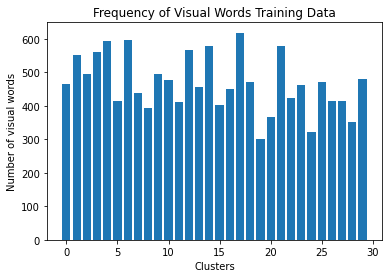

In [23]:
plt.bar(list(range(30)),ske.histogram(np.concatenate(vwr_img), 30)[0])
plt.title('Frequency of Visual Words Training Data')
plt.ylabel('Number of visual words')
plt.xlabel('Clusters')

Text(0.5, 0, 'Clusters')

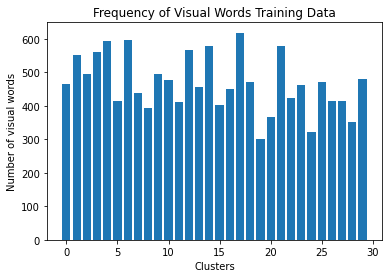

In [24]:
plt.bar(list(range(30)),ske.histogram(kmeans.labels_, 30)[0])
plt.title('Frequency of Visual Words Training Data')
plt.ylabel('Number of visual words')
plt.xlabel('Clusters')


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [26]:
dcs_flatten.shape

(14016, 256)

In [27]:
# solution
svc = SVC()
clf = GridSearchCV(svc,{'C':[0.5,1,5,8,10,15], 'gamma':['scale','auto']})
clf.fit(vwr_img,y_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.5, 1, 5, 8, 10, 15],
                         'gamma': ['scale', 'auto']})

In [28]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005249,0.001192,0.001618,0.000242,0.5,scale,"{'C': 0.5, 'gamma': 'scale'}",0.386364,0.454545,0.386364,0.363636,0.372093,0.392600,0.032170,6
1,0.004324,0.000581,0.001476,0.000045,0.5,auto,"{'C': 0.5, 'gamma': 'auto'}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,7
2,0.004437,0.000518,0.001386,0.000055,1,scale,"{'C': 1, 'gamma': 'scale'}",0.409091,0.363636,0.431818,0.409091,0.418605,0.406448,0.022971,5
3,0.004016,0.000082,0.001398,0.000029,1,auto,"{'C': 1, 'gamma': 'auto'}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,7
4,0.004373,0.000125,0.001402,0.000067,5,scale,"{'C': 5, 'gamma': 'scale'}",0.454545,0.318182,0.431818,0.500000,0.418605,0.424630,0.059991,1
5,0.004502,0.000278,0.001412,0.000068,5,auto,"{'C': 5, 'gamma': 'auto'}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,7
6,0.004577,0.000374,0.001538,0.000207,8,scale,"{'C': 8, 'gamma': 'scale'}",0.454545,0.318182,0.431818,0.500000,0.418605,0.424630,0.059991,1
7,0.004274,0.000074,0.001467,0.000160,8,auto,"{'C': 8, 'gamma': 'auto'}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,7
8,0.004459,0.000095,0.001391,0.000028,10,scale,"{'C': 10, 'gamma': 'scale'}",0.454545,0.318182,0.431818,0.500000,0.418605,0.424630,0.059991,1
9,0.004736,0.000762,0.002189,0.001475,10,auto,"{'C': 10, 'gamma': 'auto'}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,7


In [29]:
print('The scale mode of SVC would use a gamma of {}, then using auto mode would use -> {}'.format(1/(256*dcs_flatten.var()),1/256))

The scale mode of SVC would use a gamma of 0.015658588643871877, then using auto mode would use -> 0.00390625


In [30]:
# solution
svc2 = SVC()
clf2 = GridSearchCV(svc2,{'C':[1,5,10], 'gamma':[0.005,0.1,0.25,0.5,1.0]})
clf2.fit(vwr_img,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10],
                         'gamma': [0.005, 0.1, 0.25, 0.5, 1.0]})

In [31]:
import pandas as pd
pd.DataFrame(clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005159,0.001396,0.001866,0.000620,1,0.005,"{'C': 1, 'gamma': 0.005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
1,0.004011,0.000164,0.001476,0.000134,1,0.1,"{'C': 1, 'gamma': 0.1}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
2,0.003453,0.000135,0.001263,0.000042,1,0.25,"{'C': 1, 'gamma': 0.25}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
3,0.003750,0.000303,0.001459,0.000142,1,0.5,"{'C': 1, 'gamma': 0.5}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
4,0.003401,0.000066,0.001357,0.000218,1,1.0,"{'C': 1, 'gamma': 1.0}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
5,0.004537,0.000116,0.001513,0.000134,5,0.005,"{'C': 5, 'gamma': 0.005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
6,0.005916,0.001453,0.002151,0.000539,5,0.1,"{'C': 5, 'gamma': 0.1}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
7,0.003885,0.000131,0.001412,0.000132,5,0.25,"{'C': 5, 'gamma': 0.25}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
8,0.004267,0.000894,0.001361,0.000065,5,0.5,"{'C': 5, 'gamma': 0.5}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1
9,0.003703,0.000043,0.001988,0.001484,5,1.0,"{'C': 5, 'gamma': 1.0}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.01023,1


In [32]:
# solution
svc3 = SVC()
clf3 = GridSearchCV(svc3,{'C':[0.1,0.5,1,1.5], 'gamma':[0.0005,0.005,0.05,0.5]})
clf3.fit(vwr_img,y_train)
pd.DataFrame(clf3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003970,0.000122,0.001432,0.000085,0.1,0.0005,"{'C': 0.1, 'gamma': 0.0005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
1,0.004086,0.000140,0.001433,0.000059,0.1,0.005,"{'C': 0.1, 'gamma': 0.005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
2,0.003927,0.000057,0.001551,0.000302,0.1,0.05,"{'C': 0.1, 'gamma': 0.05}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
3,0.003932,0.000699,0.001400,0.000138,0.1,0.5,"{'C': 0.1, 'gamma': 0.5}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
4,0.004614,0.000475,0.001582,0.000347,0.5,0.0005,"{'C': 0.5, 'gamma': 0.0005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
5,0.004143,0.000079,0.001456,0.000090,0.5,0.005,"{'C': 0.5, 'gamma': 0.005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
6,0.003966,0.000071,0.001347,0.000018,0.5,0.05,"{'C': 0.5, 'gamma': 0.05}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
7,0.004201,0.000803,0.001557,0.000383,0.5,0.5,"{'C': 0.5, 'gamma': 0.5}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3
8,0.004464,0.000546,0.001430,0.000105,1,0.0005,"{'C': 1, 'gamma': 0.0005}",0.431818,0.454545,0.409091,0.363636,0.441860,0.420190,0.031958,1
9,0.004263,0.000173,0.001495,0.000098,1,0.005,"{'C': 1, 'gamma': 0.005}",0.386364,0.386364,0.363636,0.363636,0.372093,0.374419,0.010230,3


In [33]:
clf3

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 1.5],
                         'gamma': [0.0005, 0.005, 0.05, 0.5]})

# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


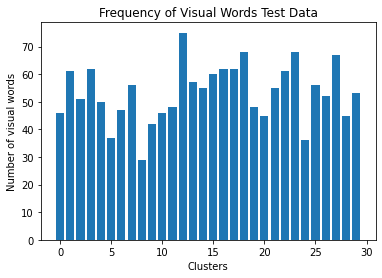

In [34]:
# solution
kps_test,dcs_test = get_multi_ORB(descriptor_extractor,x_test)
vwr_img_test = []
for img_dsc in dcs_test:
  vwr_img_test.append(kmeans.predict(img_dsc))
vwr_img_test = np.array(vwr_img_test)

plt.bar(list(range(30)),ske.histogram(np.concatenate(vwr_img_test), 30)[0])
plt.title('Frequency of Visual Words Test Data')
plt.ylabel('Number of visual words')
plt.xlabel('Clusters')

preds = clf3.predict(vwr_img_test)


*   Calculate the accuracy score for the classification model

In [35]:
preds

array(['butterfly', 'kangaroo', 'kangaroo', 'butterfly', 'kangaroo',
       'butterfly', 'butterfly', 'butterfly', 'butterfly', 'butterfly',
       'butterfly', 'kangaroo', 'kangaroo', 'kangaroo', 'kangaroo',
       'butterfly', 'butterfly', 'butterfly', 'butterfly', 'kangaroo',
       'kangaroo', 'butterfly', 'butterfly', 'kangaroo', 'butterfly'],
      dtype='<U9')

In [36]:
y_test

['dalmatian',
 'kangaroo',
 'butterfly',
 'kangaroo',
 'kangaroo',
 'butterfly',
 'dalmatian',
 'butterfly',
 'dalmatian',
 'kangaroo',
 'kangaroo',
 'dalmatian',
 'kangaroo',
 'butterfly',
 'kangaroo',
 'butterfly',
 'butterfly',
 'dalmatian',
 'butterfly',
 'butterfly',
 'dalmatian',
 'kangaroo',
 'butterfly',
 'kangaroo',
 'dalmatian']

In [37]:
# solution
print(accuracy_score(y_test, preds))

0.44


*   Generate the confusion matrix for the classification model

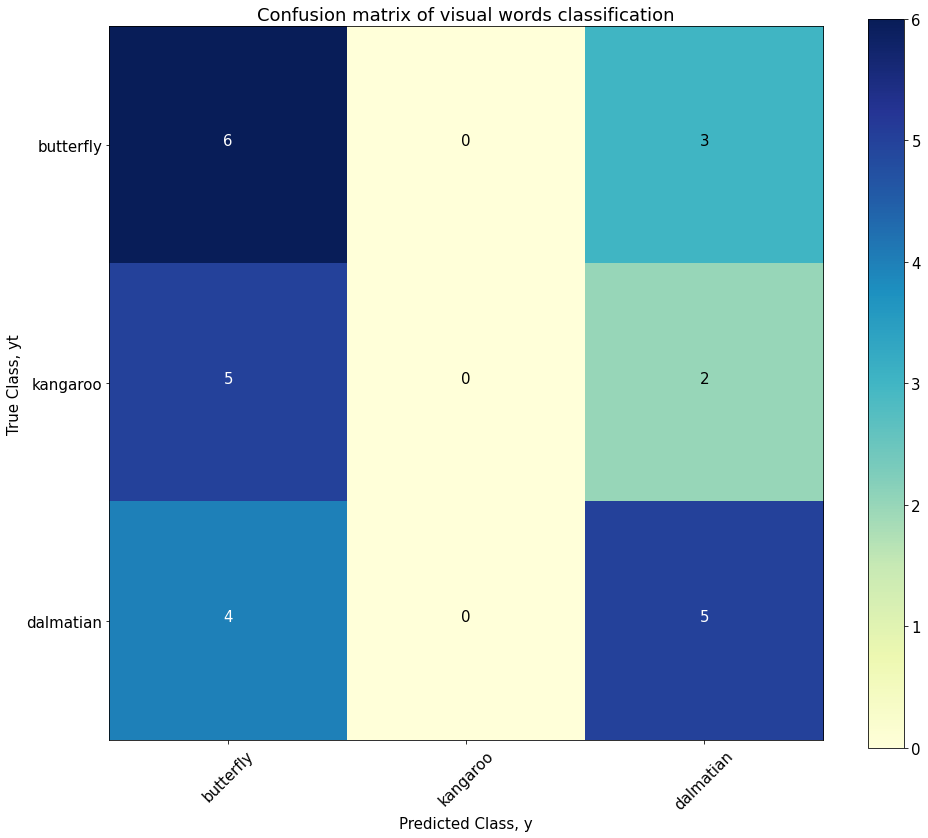

In [38]:
# solution
from customplots import plot_confusion_matrix
target_names  = list(range(30))
plot_confusion_matrix(confusion_matrix(y_test, preds),categories,False,'YlGnBu', 'Confusion matrix of visual words classification')

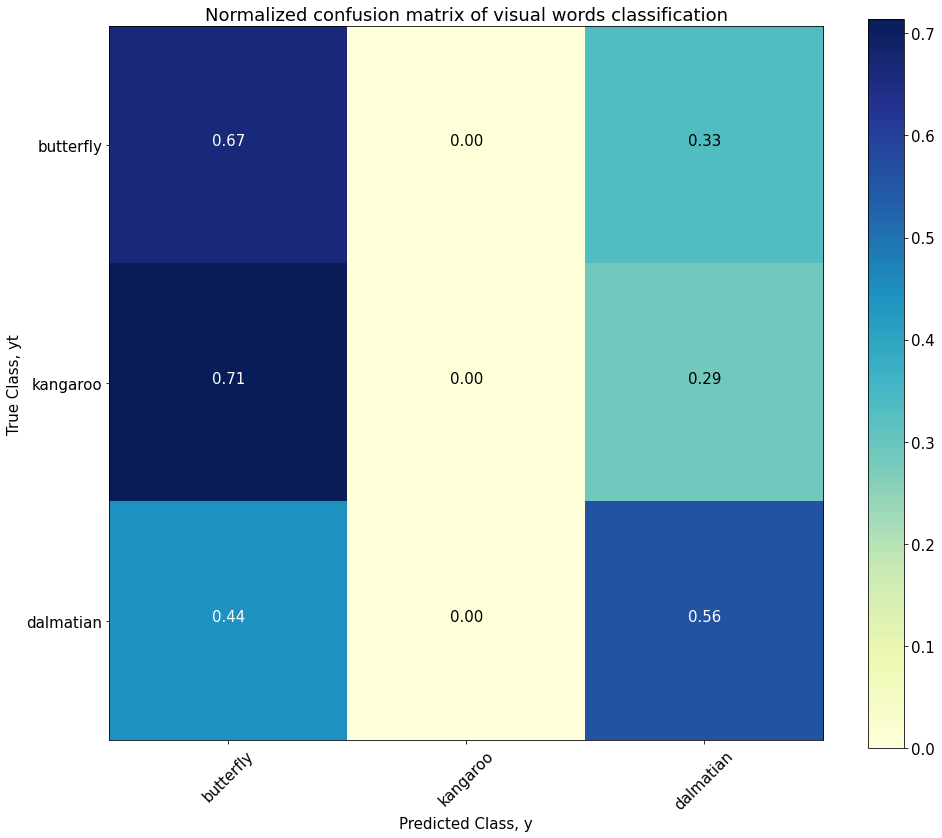

In [39]:
# solution
from customplots import plot_confusion_matrix
target_names  = list(range(30))
plot_confusion_matrix(confusion_matrix(y_test, preds),categories,True,'YlGnBu', 'Normalized confusion matrix of visual words classification',fsizes={'font':15})

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*K-means clustering is the most commonly used technique for codebook creation based on exisiting literature.*

*Some other techniques that could be used to create the codebook could be hierarchical clustering, Self-Organizing Maps, mean-shift, or other clustering methods.*

...

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [58]:
descriptor_extractor256 = feature.ORB(n_keypoints=256)
kps_train256,dcs_train256 = get_multi_ORB(descriptor_extractor256, x_train)

/content/utils.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(keypoints), np.array(descriptors)


In [51]:
set([item.shape for item in dcs_train256])

{(231, 256), (256, 256)}

In [52]:
bad_image = [n for n, item in enumerate(dcs_train256) if item.shape != (256,256)]
bad_image

[109]

In [ ]:
x_train[bad_image[0]].shape

(232, 300, 3)

In [ ]:
dcs_train256[bad_image[0]].shape

(231, 256)

In [ ]:
r = list(np.array(dcs_train256))
s = r.pop(bad_image[0])

In [ ]:
218*256

55808

In [ ]:
np.concatenate((np.reshape(np.array(r), (218*256,256)),s)).shape

(56039, 256)

In [ ]:
np.delete(list(np.array(dcs_train256)),bad_image[0]).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(218,)

/content/utils.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(keypoints), np.array(descriptors)


(56039, 256)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


#----------Accuracy on test data: 0.32 





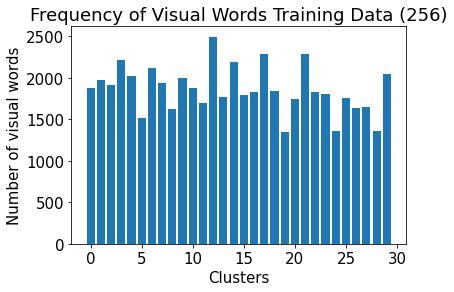

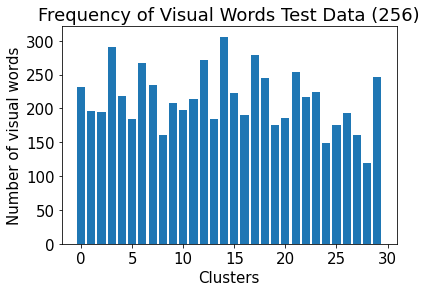

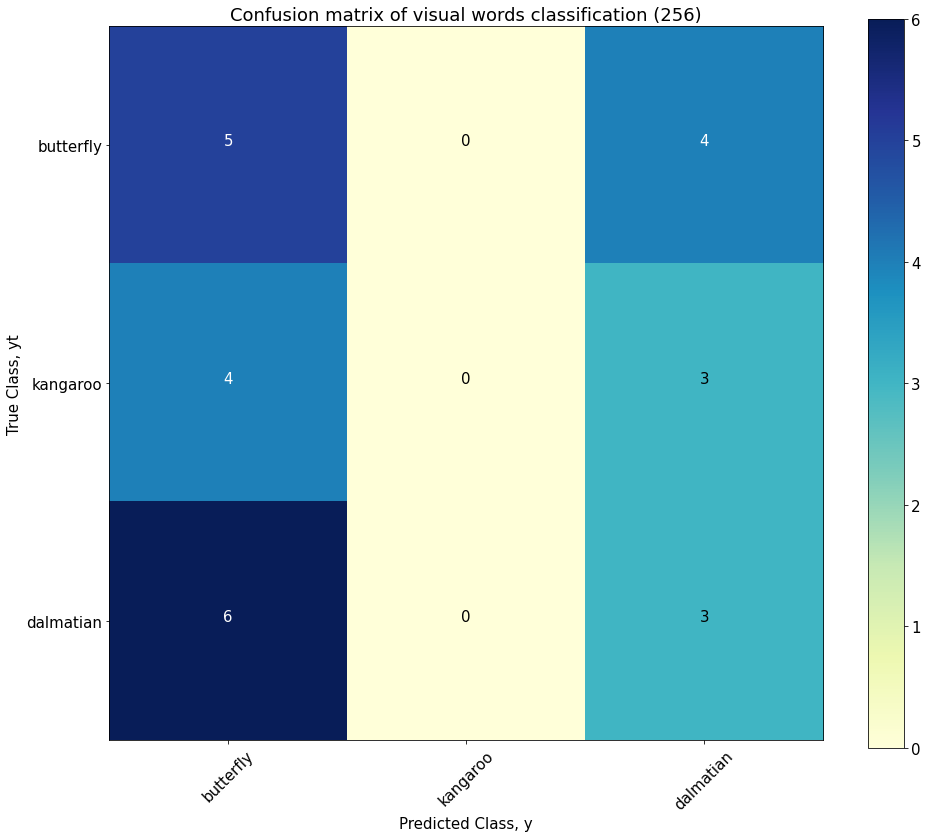

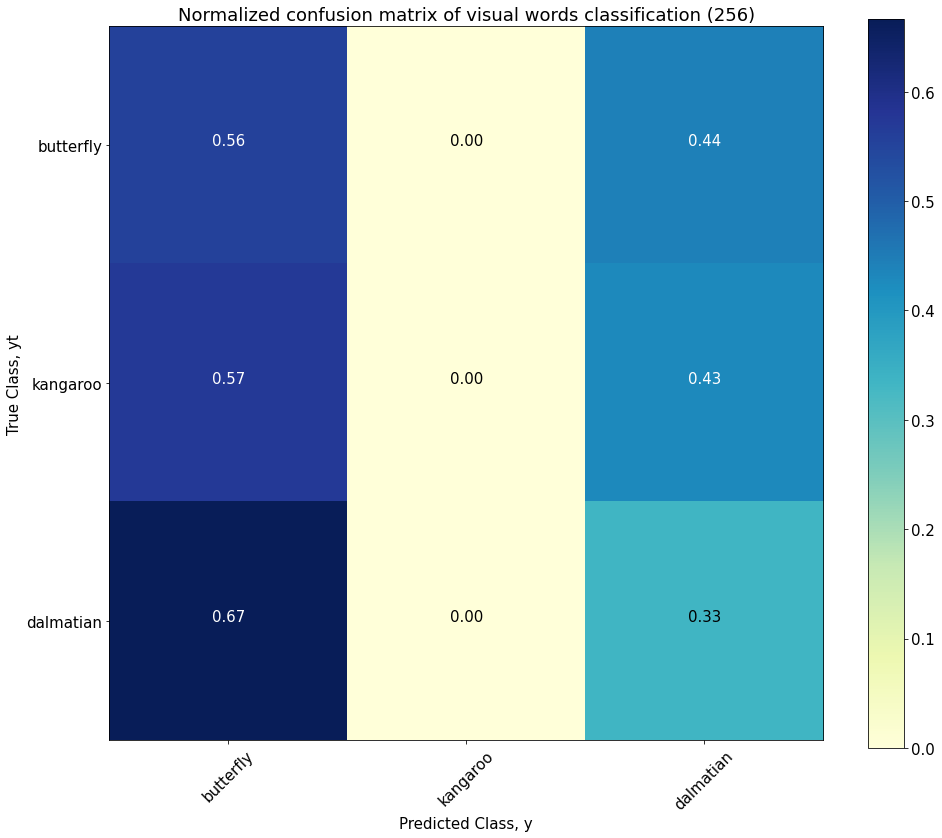

In [55]:
# Creating the descriptor ectractor for 256 keypoints
descriptor_extractor256 = feature.ORB(n_keypoints=256)

# # Getting keypoints and descriptors of train data 
kps_train256,dcs_train256 = get_multi_ORB(descriptor_extractor256, x_train)

# # One image has shape (232*300) the dimension (232) does not allow us to get 
# # 256 descriptors, we can get just 231 descriptors, this produces an error to 
# # # reshape the array, so we make a movement to extract it and add it at the end
dcs_train256 = list(dcs_train256)
deleted = dcs_train256.pop(bad_image[0])
dcs_train256 = np.array(dcs_train256)
y_train.pop(bad_image[0])

# Flattening the data and applying clustering with k-means - 30 clusters (codewords)
dcs_flatten256 = np.reshape(dcs_train256, (len(dcs_train256)*dcs_train256[0].shape[0],dcs_train256[0].shape[1]))
dcs_flatten256 = np.concatenate((dcs_flatten256,deleted)) # Adding the deleted group of image descriptors
print(dcs_flatten256.shape)
kmeans256 = MiniBatchKMeans(n_clusters=len(categories)*10).fit(dcs_flatten256)

vwr_img256 = []
# dcs_train256 = list(dcs_train256)
# dcs_train256.append(deleted)
# dcs_train256 = np.array(dcs_train256, dtype=object)
for img_dsc in dcs_train256:
  vwr_img256.append(kmeans.predict(img_dsc))
vwr_img256 = np.array(vwr_img256)

# Plotting the histogram of visual words frequencies
fig1 = plt.figure()
plt.bar(list(range(30)),ske.histogram(np.concatenate(vwr_img256), 30)[0])
plt.title('Frequency of Visual Words Training Data (256)')
plt.ylabel('Number of visual words')
plt.xlabel('Clusters')


# Looking for the best classifier model in this task
svc256 = SVC()
clf256 = GridSearchCV(svc256,{'C':[0.5,1,5,10], 'gamma':['scale','auto',0.005,0.5]}, n_jobs=4, verbose=3)
clf256.fit(vwr_img256,y_train)

# Getting keypoints and descriptors of test data, flattening & applying k-means
kps_test256,dcs_test256 = get_multi_ORB(descriptor_extractor256,x_test)
dcs_test_flatten256 =  np.reshape(dcs_test256, (len(dcs_test256)*dcs_test256.shape[1],dcs_test256.shape[2]))
tst_labs256 = kmeans256.predict(dcs_test_flatten256)

vwr_img256_test = []
for img_dsc in dcs_test256:
  vwr_img256_test.append(kmeans.predict(img_dsc))
vwr_img256_test = np.array(vwr_img256_test)

# Plotting the histogram of visual words frequencies (test data)
fig2 = plt.figure()
plt.bar(list(range(30)),ske.histogram(np.concatenate(vwr_img256_test), 30)[0])
plt.title('Frequency of Visual Words Test Data (256)')
plt.ylabel('Number of visual words')
plt.xlabel('Clusters')

# Using the trained model get predictions 
preds256 = clf256.predict(vwr_img256_test)

# Evaluate the model with accuracy and confusion
print('\n\n#----------Accuracy on test data: {} \n\n\n'.format(accuracy_score(y_test, preds256)))

plot_confusion_matrix(confusion_matrix(y_test, preds256),categories,False,'YlGnBu', 'Confusion matrix of visual words classification (256)', fsizes={'font':15})
plot_confusion_matrix(confusion_matrix(y_test, preds256),categories,True,'YlGnBu', 'Normalized confusion matrix of visual words classification (256)', fsizes={'font':15})

In [119]:
pd.DataFrame(clf256.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011637,0.002247,0.004229,0.000223,0.5,scale,"{'C': 0.5, 'gamma': 'scale'}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
1,0.012548,0.003271,0.008600,0.007732,0.5,auto,"{'C': 0.5, 'gamma': 'auto'}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
2,0.021616,0.009987,0.007489,0.006487,0.5,0.005,"{'C': 0.5, 'gamma': 0.005}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
3,0.022113,0.012065,0.005761,0.003754,0.5,0.5,"{'C': 0.5, 'gamma': 0.5}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
4,0.029732,0.009007,0.005693,0.002495,1,scale,"{'C': 1, 'gamma': 'scale'}",0.431818,0.340909,0.477273,0.441860,0.465116,0.431395,0.048040,3
5,0.023219,0.008798,0.009212,0.004560,1,auto,"{'C': 1, 'gamma': 'auto'}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
6,0.020554,0.003094,0.008522,0.004818,1,0.005,"{'C': 1, 'gamma': 0.005}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
7,0.019142,0.010503,0.007670,0.003250,1,0.5,"{'C': 1, 'gamma': 0.5}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4
8,0.023315,0.013264,0.006365,0.003865,5,scale,"{'C': 5, 'gamma': 'scale'}",0.477273,0.363636,0.500000,0.488372,0.395349,0.444926,0.054832,1
9,0.023685,0.013830,0.006629,0.003887,5,auto,"{'C': 5, 'gamma': 'auto'}",0.386364,0.363636,0.363636,0.372093,0.372093,0.371564,0.008310,4


*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

*The accuracy does not improve when using 256 keypoints, with an accuracy score of about 35%, as opposed to the accuracy score when using 64 keypoints, which was about 45%. The accuracy value will vary based on the values set for the k-means random_state and the data split random seed. In addition, using 256 keypoints is also more computationally expensive. According to the sklearn documentation, the fit time scales quadratically with the number of samples, so when there are too many samples to fit, the computational time increases.*

...

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

*When using this dataset, adding more keypoints is not feasible, since the number of keypoints cannot exceed the number of pixels in one dimension of the image. This can be seen with one image in this dataset, which had a dimension of (232 x 300) so the maximum number of descriptors that could have been used would be 231. Therefore, in this case, increasing the number of keypoints would not increase the performance of the algorithm. However, even if we add images to our dataset that have a dimension larger than 256, we would not see any significant improvement in accuracy, but would still see the increase in computational cost. To counter this increase in computational cost, it may be possible to use another classification algorithm, such as LinearSVC or SGDClassifier. Although increasing the number of keypoints will not improve accuracy, increasing the number of images in the dataset would help improve this measure.*

...


---

## **End of P3_2: Image Classification using Bag of Visual Words**
Deadline for P3_2 submission in CampusVirtual is: **Thursday, the 17th of November, 2022**